Group 2 Members: Marcos Conde, Jose Manuel Lopez Camuñas, Alex Martin Martinez

In [1]:
!pip install tqdm

In [2]:
import cv2
import numpy as np
import pickle
import os
import warnings
import pandas as pd
from tqdm import tqdm
from sklearn.cluster import MiniBatchKMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score, KFold
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

warnings.filterwarnings('ignore')

Let us first read the train and test files

In [3]:
train_images_filenames = pickle.load(open('train_images_filenames.dat','rb'))
test_images_filenames = pickle.load(open('test_images_filenames.dat','rb'))
train_images_filenames = ['..' + n[15:] for n in train_images_filenames]
test_images_filenames  = ['..' + n[15:] for n in test_images_filenames]

train_labels = pickle.load(open('train_labels.dat','rb'))
test_labels = pickle.load(open('test_labels.dat','rb'))

We create a SIFT object detector and descriptor. We compute the SIFT descriptors for all the train images and subsequently build a numpy array with all the descriptors stacked together.

In [4]:
detector = cv2.KAZE_create(threshold=0.0001)

def get_SIFT_descriptors(detector, x, y):
    descriptors = []
    label_per_descriptor = []

    for filename, labels in zip(x,y):
        ima = cv2.imread(filename)
        gray = cv2.cvtColor(ima, cv2.COLOR_BGR2GRAY)
        kpt, des = detector.detectAndCompute(gray, None)
        descriptors.append(des)
        label_per_descriptor.append(labels)

    descriptors_np = np.vstack(descriptors)

    return descriptors_np, descriptors, label_per_descriptor

train_descriptors_np, train_descriptors, train_label_per_descriptor = get_SIFT_descriptors(detector, train_images_filenames, train_labels)
test_descriptors_np, test_descriptors, test_label_per_descriptor = get_SIFT_descriptors(detector, test_images_filenames, test_labels)

We now compute a k-means clustering on the descriptor space and, for each train image, we project each keypoint descriptor to its closest visual word. We represent each of the images with the frequency of each visual word.

In [5]:
k = 128
codebook = MiniBatchKMeans(n_clusters=k, verbose=False, batch_size=k * 20,compute_labels=False,reassignment_ratio=10**-4,random_state=42)

def get_visual_words(descriptors,descriptors_np,codebook,k,test=False):
    
    if not test:
        codebook.fit(descriptors_np)
        
    visual_words = np.zeros((len(descriptors), k), dtype=np.float32)
    
    for i in range(len(descriptors)):
        words = codebook.predict(descriptors[i])
        visual_words[i,:] = np.bincount(words, minlength=k)
    
    return words, visual_words

words_train, visual_words_train = get_visual_words(train_descriptors,train_descriptors_np,codebook,k)
words_test, visual_words_test = get_visual_words(test_descriptors,test_descriptors_np,codebook,k,test=True)

In [6]:
a = np.array([1,2,3,4,5])
b = np.array([6,7,8,9,10])



 We build a k-nn classifier, train it with the train descriptors and computing the test descriptors and compute the accuracy of the model

In [7]:
def evaluate_knn(visual_words_train, visual_words_test,n_neighbors=5, metric='euclidean', cross_val = True):
    if not cross_val:
        knn = KNeighborsClassifier(n_neighbors=n_neighbors,n_jobs=-1,metric=metric)
        knn.fit(visual_words_train, train_labels) 
        accuracy = 100*knn.score(visual_words_test, test_labels)
        return accuracy
    
    kf = KFold(n_splits=5, random_state=42, shuffle=True)
    accuracy = 0
    
    for train_index, test_index in kf.split(visual_words_train):
        X_train, X_test = visual_words_train[train_index], visual_words_train[test_index]
        y_train, y_test = np.array(train_labels)[train_index.astype(int)], np.array(train_labels)[test_index.astype(int)]
        
        X_test, y_test = np.concatenate((X_test,visual_words_test)), np.concatenate((y_test,test_labels))
        
        knn = KNeighborsClassifier(n_neighbors=n_neighbors,n_jobs=-1,metric=metric)
        knn.fit(X_train, y_train)
        
        accuracy += 100*knn.score(X_test, y_test)
    
    return accuracy/5
        
        
evaluate_knn(visual_words_train, visual_words_test, n_neighbors=5, metric='euclidean')

57.42049530511069

Dimensionality reduction, with PCA and LDA

In [8]:
def evaluate_pca(visual_words_train, visual_words_test,n_components=64,n_neighbors=5,metric='euclidean', cross_val = True):
    if not cross_val:
        pca = PCA(n_components=n_components)
        VWpca = pca.fit_transform(visual_words_train)
        knnpca = KNeighborsClassifier(n_neighbors=n_neighbors,n_jobs=-1,metric=metric)
        knnpca.fit(VWpca, train_labels) 
        vwtestpca = pca.transform(visual_words_test)
        accuracy = 100*knnpca.score(vwtestpca, test_labels)
        return accuracy
    
    kf = KFold(n_splits=5, random_state=42, shuffle=True)
    accuracy = 0
    
    for train_index, test_index in kf.split(visual_words_train):
        X_train, X_test = visual_words_train[train_index], visual_words_train[test_index]
        y_train, y_test = np.array(train_labels)[train_index.astype(int)], np.array(train_labels)[test_index.astype(int)]   
        X_test, y_test = np.concatenate((X_test,visual_words_test)), np.concatenate((y_test,test_labels))
        pca = PCA(n_components=n_components)
        VWpca = pca.fit_transform(X_train)
        knnpca = KNeighborsClassifier(n_neighbors=n_neighbors,n_jobs=-1,metric=metric)
        knnpca.fit(VWpca, y_train)
        vwtestpca = pca.transform(X_test)
        accuracy += 100*knnpca.score(vwtestpca, y_test)
        
    
    return accuracy/5

evaluate_pca(visual_words_train, visual_words_test,n_components=64,n_neighbors=5,metric='euclidean')

58.113519796212096

In [9]:
def evaluate_lda(visual_words_train, visual_words_test,n_components=7,n_neighbors=5,metric='euclidean', cross_val = True):
    if not cross_val:
        lda = LinearDiscriminantAnalysis(n_components=n_components)
        VWlda = lda.fit_transform(visual_words_train,train_labels)
        knnlda = KNeighborsClassifier(n_neighbors=5,n_jobs=-1,metric='euclidean')
        knnlda.fit(VWlda, train_labels) 
        vwtestlda = lda.transform(visual_words_test)
        accuracy = 100*knnlda.score(vwtestlda, test_labels)
        return accuracy
    
    kf = KFold(n_splits=5, random_state=42, shuffle=True)
    accuracy = 0
    
    for train_index, test_index in kf.split(visual_words_train):
        X_train, X_test = visual_words_train[train_index], visual_words_train[test_index]
        y_train, y_test = np.array(train_labels)[train_index.astype(int)], np.array(train_labels)[test_index.astype(int)]   
        X_test, y_test = np.concatenate((X_test,visual_words_test)), np.concatenate((y_test,test_labels))
        lda = LinearDiscriminantAnalysis(n_components=n_components)
        VWlda = lda.fit_transform(X_train ,y_train)
        knnlda = KNeighborsClassifier(n_neighbors=n_neighbors,n_jobs=-1,metric=metric)
        knnlda.fit(VWlda, y_train)
        vwtestlda = lda.transform(X_test)
        accuracy += 100*knnlda.score(vwtestlda, y_test)
        
    
    return accuracy/5
    
evaluate_lda(visual_words_train, visual_words_test,n_components=7,n_neighbors=5,metric='euclidean')

63.79300792762331

# SIFT with different amount of local features

In [10]:
def evaluate_SIFT(nfeatures=1000,k=128):
    print("Evaluating SIFT with {} features".format(nfeatures))
    print(50*"-")
    detector = cv2.xfeatures2d.SIFT_create(nfeatures=nfeatures)
    train_descriptors_np, train_descriptors, train_label_per_descriptor = get_SIFT_descriptors(detector, train_images_filenames, train_labels)
    test_descriptors_np, test_descriptors, test_label_per_descriptor = get_SIFT_descriptors(detector, test_images_filenames, test_labels)

    words_train, visual_words_train = get_visual_words(train_descriptors,train_descriptors_np,codebook,k)
    words_test, visual_words_test = get_visual_words(test_descriptors,test_descriptors_np,codebook,k,test=True)

    knn_acc = evaluate_knn(visual_words_train, visual_words_test, n_neighbors=5, metric='euclidean')
    pca_acc = evaluate_pca(visual_words_train, visual_words_test, n_components=64,n_neighbors=5,metric='euclidean')
    lda_acc = evaluate_lda(visual_words_train, visual_words_test, n_components=7,n_neighbors=5,metric='euclidean')
    return [knn_acc,pca_acc,lda_acc]
    


opt = [100, 500, 1000, 2500, 5000, 10000]

results = {}

for n in opt:   
    results[str(n)+" features"] = evaluate_SIFT(nfeatures=n)

Evaluating SIFT with 100 features
--------------------------------------------------
Evaluating SIFT with 500 features
--------------------------------------------------
Evaluating SIFT with 1000 features
--------------------------------------------------
Evaluating SIFT with 2500 features
--------------------------------------------------
Evaluating SIFT with 5000 features
--------------------------------------------------
Evaluating SIFT with 10000 features
--------------------------------------------------


In [11]:
import matplotlib.pyplot as plt

df = pd.DataFrame.from_dict(results, orient='index')
df.columns = ["KNN", "KNN-PCA", "KNN-LDA"]
df

,KNN,KNN-PCA,KNN-LDA
100 features,41.075198,37.457706,46.348681
500 features,57.166988,57.792474,60.851734
1000 features,57.623141,59.364377,61.629475
2500 features,58.569886,58.874340,61.358805
5000 features,58.569886,58.772903,61.358805
10000 features,58.569886,58.637668,61.358805


<AxesSubplot:>

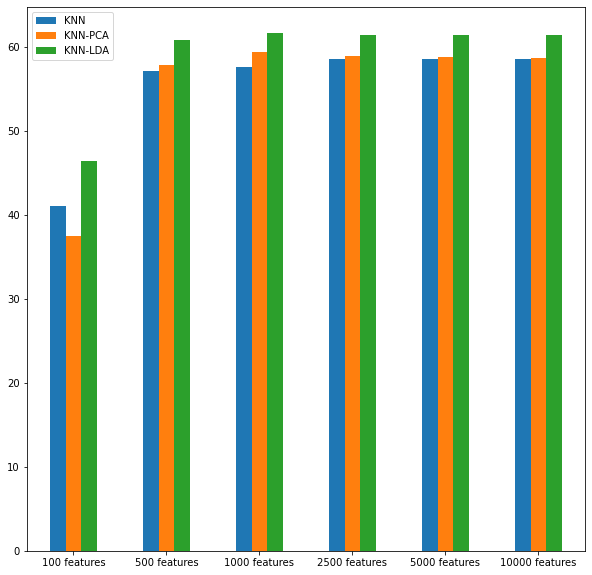

In [12]:
df.plot(kind="bar",figsize=(10,10), rot=0)

When augmenting the number of features used to produce de BoVW we obtain better results overall until a certain precission is reached when using more features doesn't get better precission. In the case of KNN used with PCA we can observe that the precission even get worse when using more features as it may be reducing the dimensionality of the feature space using directions that are not useful to the clasification. 

# Try Dense SIFT

In [13]:
def get_dense_SIFT_features(images, lbls, nfeatures=5000):
    descriptors = []
    label_per_descriptor = []
    descriptors_np = None
    sift = cv2.xfeatures2d.SIFT_create(nfeatures=nfeatures)
    
    for filename, labels in zip(images,lbls):
        ima = cv2.imread(filename)
        gray = cv2.cvtColor(ima, cv2.COLOR_BGR2GRAY)
        step_size = 5
        kp = [cv2.KeyPoint(x, y, step_size) for y in range(0, gray.shape[0], step_size) 
                                        for x in range(0, gray.shape[1], step_size)]
        
        kp, des = sift.compute(gray, kp)
        descriptors.append(des)
        label_per_descriptor.append(labels)
    
    descriptors_np = np.vstack(descriptors)

    
    return descriptors_np, descriptors, label_per_descriptor

In [14]:
def evaluate_dense_SIFT(nfeatures=5000, k=128):
    print("Evaluating Dense SIFT with {} features".format(nfeatures))
    print(50*"-")
    train_descriptors_np, train_descriptors, train_label_per_descriptor = get_dense_SIFT_features(train_images_filenames, train_labels, nfeatures)
    test_descriptors_np, test_descriptors, test_label_per_descriptor = get_dense_SIFT_features(test_images_filenames, test_labels, nfeatures)

    words_train, visual_words_train = get_visual_words(train_descriptors,train_descriptors_np,codebook,k)
    words_test, visual_words_test = get_visual_words(test_descriptors,test_descriptors_np,codebook,k,test=True)

    knn_acc = evaluate_knn(visual_words_train, visual_words_test, n_neighbors=5, metric='euclidean')
    pca_acc = evaluate_pca(visual_words_train, visual_words_test, n_components=64,n_neighbors=5,metric='euclidean')
    lda_acc = evaluate_lda(visual_words_train, visual_words_test, n_components=7,n_neighbors=5,metric='euclidean')
    return [knn_acc,pca_acc,lda_acc]

In [15]:
results_keys = ["Dense SIFT", "SIFT"]
results_list = [evaluate_dense_SIFT(nfeatures=5000), evaluate_SIFT(nfeatures=5000)]
results = dict(zip(results_keys,results_list))
df = pd.DataFrame.from_dict(results, orient='index')
df.columns = ["KNN", "KNN-PCA", "KNN-LDA"]
df

Evaluating Dense SIFT with 5000 features
--------------------------------------------------
Evaluating SIFT with 5000 features
--------------------------------------------------


,KNN,KNN-PCA,KNN-LDA
Dense SIFT,70.571383,71.010829,79.428560
SIFT,58.569886,58.772889,61.358805


<AxesSubplot:>

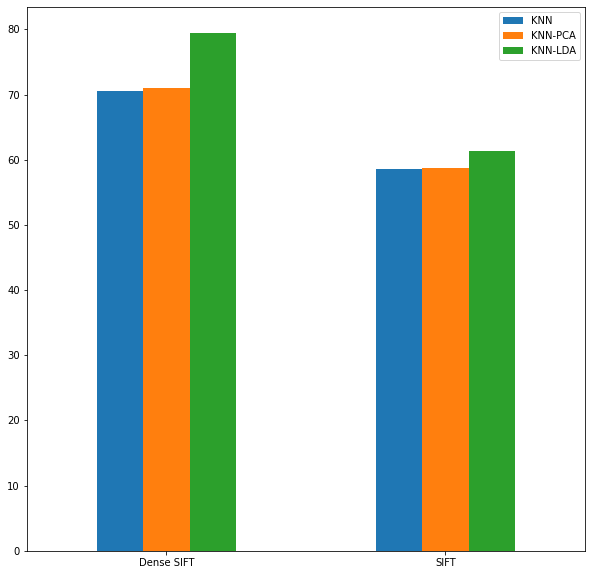

In [16]:
df.plot(kind="bar",figsize=(10,10), rot=0)

When using Dense sift we can observe significant better results at all the methods tested. Using local features obtained with a certain regularity in the image improves the performance of the BoVW. 

# Different codebook k sizes

In [17]:
def evaluate_SIFT_k_codebook(nfeatures=5000,k=128):
    print("Evaluating SIFT with {} features and k={}".format(nfeatures,k))
    print(50*"-")
    codebook = MiniBatchKMeans(n_clusters=k, verbose=False, batch_size=k * 20,compute_labels=False,reassignment_ratio=10**-4,random_state=42)
    detector = cv2.xfeatures2d.SIFT_create(nfeatures=nfeatures)
    train_descriptors_np, train_descriptors, train_label_per_descriptor = get_SIFT_descriptors(detector, train_images_filenames, train_labels)
    test_descriptors_np, test_descriptors, test_label_per_descriptor = get_SIFT_descriptors(detector, test_images_filenames, test_labels)

    words_train, visual_words_train = get_visual_words(train_descriptors,train_descriptors_np,codebook,k)
    words_test, visual_words_test = get_visual_words(test_descriptors,test_descriptors_np,codebook,k,test=True)

    knn_acc = evaluate_knn(visual_words_train, visual_words_test, n_neighbors=5, metric='euclidean')
    pca_acc = evaluate_pca(visual_words_train, visual_words_test, n_components=int(k/2),n_neighbors=5,metric='euclidean')
    lda_acc = evaluate_lda(visual_words_train, visual_words_test, n_components=7,n_neighbors=5,metric='euclidean')
    return [knn_acc,pca_acc,lda_acc]
    


opt = [32, 64, 128, 256, 512, 1024]

results = {}

for n in opt:   
    results["k = "+str(n)] = evaluate_SIFT_k_codebook(nfeatures=5000, k=n)

Evaluating SIFT with 5000 features and k=32
--------------------------------------------------
Evaluating SIFT with 5000 features and k=64
--------------------------------------------------
Evaluating SIFT with 5000 features and k=128
--------------------------------------------------
Evaluating SIFT with 5000 features and k=256
--------------------------------------------------
Evaluating SIFT with 5000 features and k=512
--------------------------------------------------
Evaluating SIFT with 5000 features and k=1024
--------------------------------------------------


In [18]:
df = pd.DataFrame.from_dict(results, orient='index')
df.columns = ["KNN", "KNN-PCA", "KNN-LDA"]
df

,KNN,KNN-PCA,KNN-LDA
k = 32,51.960816,51.859308,55.020362
k = 64,54.935874,54.902047,59.837978
k = 128,58.569886,58.874126,61.358805
k = 256,55.933066,57.352899,60.733362
k = 512,49.881785,54.225786,56.896561
k = 1024,36.038059,42.562727,42.934420


<AxesSubplot:>

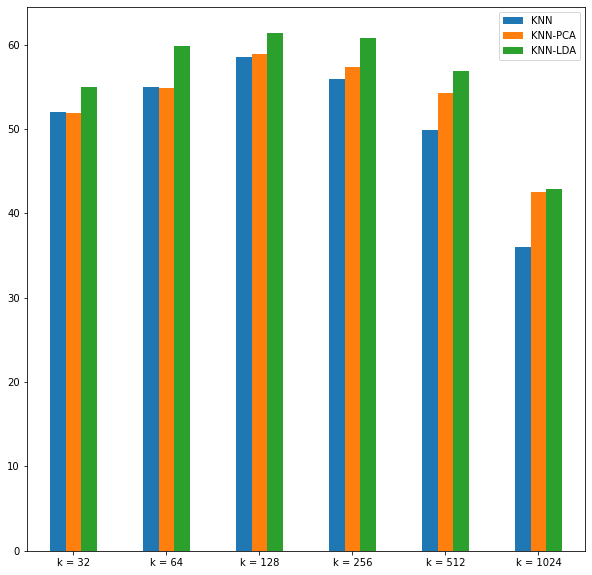

In [19]:
df.plot(kind="bar",figsize=(10,10), rot=0)

When varying the codebook sizes the number of bins used to produce the histograms changes. In this test we observe that for the three methods when 128 was used as the codebook size the results were better.

# Different N_Neighbors for KNN

In [20]:
def evaluate_SIFT_n_neighbors(nfeatures=5000,k=128,n_neighbors=5):
    print("Evaluating SIFT with {} features and k={} and n_neighbors={}".format(nfeatures,k, n_neighbors))
    print(50*"-")
    codebook = MiniBatchKMeans(n_clusters=k, verbose=False, batch_size=k * 20,compute_labels=False,reassignment_ratio=10**-4,random_state=42)
    detector = cv2.xfeatures2d.SIFT_create(nfeatures=nfeatures)
    train_descriptors_np, train_descriptors, train_label_per_descriptor = get_SIFT_descriptors(detector, train_images_filenames, train_labels)
    test_descriptors_np, test_descriptors, test_label_per_descriptor = get_SIFT_descriptors(detector, test_images_filenames, test_labels)

    words_train, visual_words_train = get_visual_words(train_descriptors,train_descriptors_np,codebook,k)
    words_test, visual_words_test = get_visual_words(test_descriptors,test_descriptors_np,codebook,k,test=True)

    knn_acc = evaluate_knn(visual_words_train, visual_words_test, n_neighbors=n_neighbors, metric='euclidean')
    pca_acc = evaluate_pca(visual_words_train, visual_words_test, n_components=int(k/2),n_neighbors=n_neighbors,metric='euclidean')
    lda_acc = evaluate_lda(visual_words_train, visual_words_test, n_components=7,n_neighbors=n_neighbors,metric='euclidean')
    return [knn_acc,pca_acc,lda_acc]
    


opt = [2, 3, 4, 5, 6, 7, 8, 9, 10]

results = {}

for n in opt:   
    results["n = "+str(n)] = evaluate_SIFT_n_neighbors(nfeatures=5000, k=128, n_neighbors=n)

Evaluating SIFT with 5000 features and k=128 and n_neighbors=2
--------------------------------------------------
Evaluating SIFT with 5000 features and k=128 and n_neighbors=3
--------------------------------------------------
Evaluating SIFT with 5000 features and k=128 and n_neighbors=4
--------------------------------------------------
Evaluating SIFT with 5000 features and k=128 and n_neighbors=5
--------------------------------------------------
Evaluating SIFT with 5000 features and k=128 and n_neighbors=6
--------------------------------------------------
Evaluating SIFT with 5000 features and k=128 and n_neighbors=7
--------------------------------------------------
Evaluating SIFT with 5000 features and k=128 and n_neighbors=8
--------------------------------------------------
Evaluating SIFT with 5000 features and k=128 and n_neighbors=9
--------------------------------------------------
Evaluating SIFT with 5000 features and k=128 and n_neighbors=10
------------------------

In [21]:
df = pd.DataFrame.from_dict(results, orient='index')
df.columns = ["KNN", "KNN-PCA", "KNN-LDA"]
df

,KNN,KNN-PCA,KNN-LDA
n = 2,51.419976,52.637034,54.715993
n = 3,56.592221,57.386597,59.381297
n = 4,57.302295,58.299459,60.462935
n = 5,58.569886,58.924887,61.358805
n = 6,59.263011,59.094049,61.696843
n = 7,59.059994,59.448879,62.119511
n = 8,59.550302,59.736427,62.254761
n = 9,59.246076,59.449093,62.220920
n = 10,59.313644,60.124983,62.626696


<AxesSubplot:>

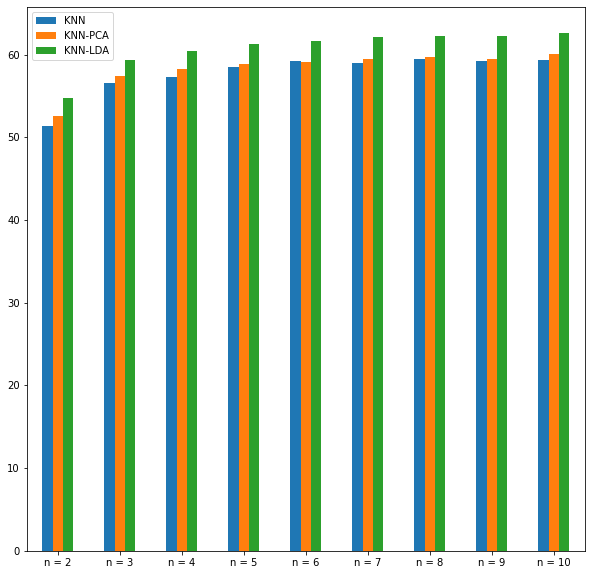

In [22]:
df.plot(kind="bar",figsize=(10,10), rot=0)

When varying this parameter we can observe that the perform of all the methods gets better as the number of neighbours taken into account to determine the label of the image is bigger. 

# Different Metrics for KNN

In [26]:
def evaluate_SIFT_knn_metric(nfeatures=5000,k=128,n_neighbors=5, metric="euclidean", cross_val=True):
    print("Evaluating SIFT with {} features and k={} and n_neighbors={} and metric={}".format(nfeatures,k, n_neighbors, metric))
    print(50*"-")
    codebook = MiniBatchKMeans(n_clusters=k, verbose=False, batch_size=k * 20,compute_labels=False,reassignment_ratio=10**-4,random_state=42)
    detector = cv2.xfeatures2d.SIFT_create(nfeatures=nfeatures)
    train_descriptors_np, train_descriptors, train_label_per_descriptor = get_SIFT_descriptors(detector, train_images_filenames, train_labels)
    test_descriptors_np, test_descriptors, test_label_per_descriptor = get_SIFT_descriptors(detector, test_images_filenames, test_labels)

    words_train, visual_words_train = get_visual_words(train_descriptors,train_descriptors_np,codebook,k)
    words_test, visual_words_test = get_visual_words(test_descriptors,test_descriptors_np,codebook,k,test=True)

    knn_acc = evaluate_knn(visual_words_train, visual_words_test, n_neighbors=n_neighbors, metric=metric, cross_val=cross_val)
    pca_acc = evaluate_pca(visual_words_train, visual_words_test, n_components=int(k/2),n_neighbors=n_neighbors,metric=metric, cross_val=cross_val)
    lda_acc = evaluate_lda(visual_words_train, visual_words_test, n_components=7,n_neighbors=n_neighbors,metric=metric, cross_val=cross_val)
    return [knn_acc,pca_acc,lda_acc]
    


    
cross_val = True
opt = ["euclidean","manhattan","chebyshev","minkowski","seuclidean","mahalanobis"]

if cross_val:
    opt.remove("seuclidean")
    opt.remove("mahalanobis")

results = {}

for n in opt:   
    results[str(n)] = evaluate_SIFT_knn_metric(nfeatures=5000, k=128, n_neighbors=5, metric=n, cross_val=cross_val)

Evaluating SIFT with 5000 features and k=128 and n_neighbors=5 and metric=euclidean
--------------------------------------------------
Evaluating SIFT with 5000 features and k=128 and n_neighbors=5 and metric=manhattan
--------------------------------------------------
Evaluating SIFT with 5000 features and k=128 and n_neighbors=5 and metric=chebyshev
--------------------------------------------------
Evaluating SIFT with 5000 features and k=128 and n_neighbors=5 and metric=minkowski
--------------------------------------------------


In [27]:
df = pd.DataFrame.from_dict(results, orient='index')
df.columns = ["KNN", "KNN-PCA", "KNN-LDA"]
df

,KNN,KNN-PCA,KNN-LDA
euclidean,58.569886,59.347556,61.358805
manhattan,55.966993,56.389547,60.767232
chebyshev,47.582689,56.541589,60.902595
minkowski,58.569886,59.296952,61.358805


<AxesSubplot:>

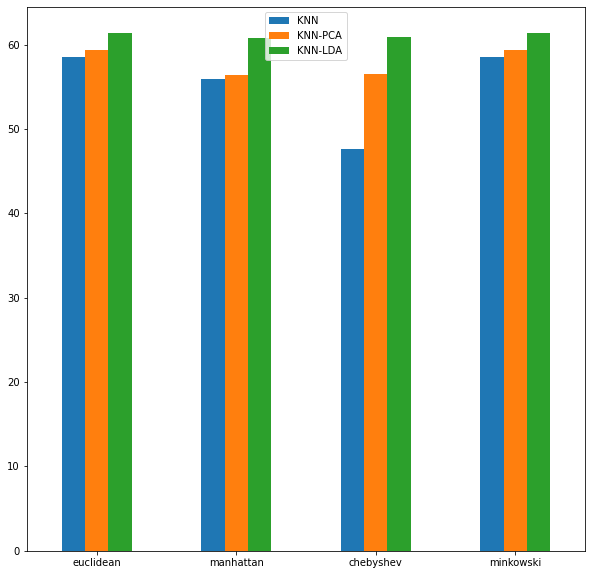

In [28]:
df.plot(kind="bar",figsize=(10,10), rot=0)

The methods perform differently depending on the metric used to determine the distance of the features. Euclidean and minkowski metrics are the best ones and have very similar performances in the three methods. When using the chebyshev metric the results get significantly worse with the KNN without any reduction of the dimensions being the most affected by it. On the other hand KNN with LDA doesn't vary a lot from the rest of the metrics. For the KNN with PCA the manhattan and chebyshev metrics get worse results. The metric changes how the distance between the points at the feature space are being calculated woth respect to the point to be labelled. This affects directly to which points will be the closest to the points to be classified and affects the final result.  

# Reducing Dimensionality

In [36]:
def evaluate_SIFT_dimensionality(nfeatures=5000,k=128,n_neighbors=5, metric="euclidean", pca=64, lda=7, cross_val=True):
    print("Evaluating SIFT with {} features and k={} and n_neighbors={} and metric={} and pca={} and lda={}".format(nfeatures,k, n_neighbors, metric, pca, lda))
    print(50*"-")
    codebook = MiniBatchKMeans(n_clusters=k, verbose=False, batch_size=k * 20,compute_labels=False,reassignment_ratio=10**-4,random_state=42)
    detector = cv2.xfeatures2d.SIFT_create(nfeatures=nfeatures)
    train_descriptors_np, train_descriptors, train_label_per_descriptor = get_SIFT_descriptors(detector, train_images_filenames, train_labels)
    test_descriptors_np, test_descriptors, test_label_per_descriptor = get_SIFT_descriptors(detector, test_images_filenames, test_labels)

    words_train, visual_words_train = get_visual_words(train_descriptors,train_descriptors_np,codebook,k)
    words_test, visual_words_test = get_visual_words(test_descriptors,test_descriptors_np,codebook,k,test=True)

    pca_acc = evaluate_pca(visual_words_train, visual_words_test, n_components=int(pca),n_neighbors=n_neighbors,metric=metric,cross_val=cross_val)
    lda_acc = evaluate_lda(visual_words_train, visual_words_test, n_components=int(lda),n_neighbors=n_neighbors,metric=metric,cross_val=cross_val)
    return [pca_acc,lda_acc]
    


cross_val = True
opt = [(8,3),(16, 5),(32, 7),(64, 9),(96, 11), (128, 13)]

if cross_val:
    opt = opt[:-3]

results = {}

for n1,n2 in opt:   
    results["pca="+str(n1)+" lda="+str(n2)] = evaluate_SIFT_dimensionality(nfeatures=5000,k=128, n_neighbors=5, metric="euclidean", pca=n1, lda=n2, cross_val=cross_val)

Evaluating SIFT with 5000 features and k=128 and n_neighbors=5 and metric=euclidean and pca=8 and lda=3
--------------------------------------------------
Evaluating SIFT with 5000 features and k=128 and n_neighbors=5 and metric=euclidean and pca=16 and lda=5
--------------------------------------------------
Evaluating SIFT with 5000 features and k=128 and n_neighbors=5 and metric=euclidean and pca=32 and lda=7
--------------------------------------------------


In [37]:
df = pd.DataFrame.from_dict(results, orient='index')
df.columns = ["KNN-PCA", "KNN-LDA"]
df

,KNN-PCA,KNN-LDA
pca=8 lda=3,56.964200,52.434289
pca=16 lda=5,60.818122,59.584200
pca=32 lda=7,59.465771,61.358805


<AxesSubplot:>

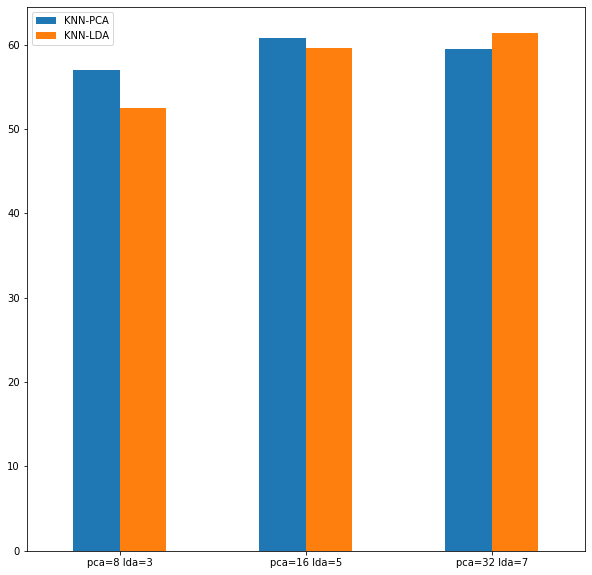

In [38]:
df.plot(kind="bar", figsize=(10,10), rot=0)

At both methods we can observe that performing a dimension reduction that uses not enough dimensions can have a negative impact in the performance. As too few dimensions are being used the algorithms are not capable to keep the important information to produce the label classification afterwards. 